# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import cv2
import os

'''
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, GlobalAveragePooLlng2D
from tensorflow.python.keras.layers import Dense
#from tensorflow.keras.layers import GlobalAveragePooLlng2D
from tensorflow.keras.callbacks import EarlyStopping
'''

'''
from tensorflow.python.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras_applications.imagenet_utils import _obtain_input_shape
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from keras_vggface import utils
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
import warnings
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
'''

2024-11-12 13:48:51.959705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731437331.974067  129949 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731437331.978335  129949 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 13:48:51.992612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'\nfrom tensorflow.python.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D,     GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization,     AveragePooling2D, Reshape, Permute, multiply\nfrom keras_applications.imagenet_utils import _obtain_input_shape\nfrom tensorflow.python.keras.utils.data_utils import get_file\nfrom tensorflow.python.keras import backend as K\nfrom keras_vggface import utils\nfrom tensorflow.python.keras.utils.layer_utils import get_source_inputs\nimport warnings\nfrom tensorflow.python.keras.models import Model\nfrom tensorflow.python.keras import layers\n'

# Load & Read Data

In [2]:
# Define paths
# image_dir = '/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images/'
# labels_csv = '/kaggle/input/computer-vision-xm/train.csv'
image_dir = './data/computer-vision-xm/Reorganized_Data/images/'
labels_csv = './data/computer-vision-xm/train.csv'
# Load the CSV file with labels
labels_df = pd.read_csv(labels_csv)

# Display the first few rows
labels_df.head()

,Unnamed: 0,Images,Labels
0,0,0003_0074.JPG,0
1,1,0004_0182.JPG,0
2,2,0018_0063.JPG,1
3,3,0009_0284.JPG,0
4,4,0020_0071.JPG,1


# Preprocessing

In [3]:
# Image size and batch size
IMG_SIZE = 128 #128, 224 
BATCH_SIZE = 32

# Load and resize images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize
    return image

# Apply preprocessing to all images
images = []
labels = []

for i, row in labels_df.iterrows():
    image_path = os.path.join(image_dir, row['Images'])
    images.append(load_and_preprocess_image(image_path))
    labels.append(row['Labels'])

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Split The Data

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")

Training data: (2710, 128, 128, 3), Validation data: (678, 128, 128, 3)


# Data Augmentation

In [5]:
# Image data generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

# Apply to training and validation data
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, target_size=(224, 224))
# val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, target_size=(224, 224))

# Create data generators for training and validation
'''
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'path/to/train/data',
        target_size=(224, 224))

val_generator = val_datagen.flow_from_directory(
        'path/to/val/data',
        target_size=(224, 224))
'''

"\ntrain_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)\nval_datagen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = train_datagen.flow_from_directory(\n        'path/to/train/data',\n        target_size=(224, 224))\n\nval_generator = val_datagen.flow_from_directory(\n        'path/to/val/data',\n        target_size=(224, 224))\n"

# Load the InceptionV3 model

In [6]:
class CustomGlobalAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomGlobalAveragePooling2D, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.keras.backend.mean(inputs, axis=[1, 2])


In [7]:
# Load the InceptionV3 model
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE, 3))

# Freeze the base model layers
for layer in model.layers:
    layer.trainable = False

# Add custom layers
'''
x = model.output
x = MaxPooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x) # 2 classes: healthy and diseased;  1, activation='sigmoid' ;2 ,activation='softmax'

# Create the final model
# model = tf.keras.Model(inputs=model.input, outputs=x)
x = model.output
x = Flatten()(x)  # Flatten the output to a 1D array

x = model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x) # 2 classes: healthy and diseased
'''

x = model.output
x = CustomGlobalAveragePooling2D()(x)  # Global Average Pooling
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x) # 2 classes: healthy and diseased

model = tf.keras.Model(inputs=model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', #categorical_crossentropy binary_crossentropy
              metrics=['accuracy'])

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model summary
# model.summary()

I0000 00:00:1731437627.976371  129949 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


# Training The Model

In [8]:

# Train the model
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=50, # High number of epochs to allow early stopping to decide when to stop
        callbacks=[early_stopping]) 

  # Save model ./models/saved_leaf_category_model.keras
model.save('./models/saved_leaf_disease.keras')      


Epoch 1/50


/home/bob35/GBC/VScode4MD2/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731437634.519641  131828 service.cc:148] XLA service 0x741a84001e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731437634.519655  131828 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-11-12 13:53:54.661262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731437635.758728  131828 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/84 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.4121 - loss: 1.1171

I0000 00:00:1731437638.990201  131828 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.5829 - loss: 0.8096 - val_accuracy: 0.6949 - val_loss: 0.6555
Epoch 2/50
 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7188 - loss: 0.8240

2024-11-12 13:54:13.613600: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-12 13:54:13.613800: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/local/lib/python3.11/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7188 - loss: 0.8240 - val_accuracy: 0.8333 - val_loss: 0.3220
Epoch 3/50
 1/84 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.7500 - loss: 0.4703

2024-11-12 13:54:16.757972: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7387 - loss: 0.5142 - val_accuracy: 0.7485 - val_loss: 0.5134
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step - accuracy: 0.6875 - loss: 0.5653 - val_accuracy: 0.5000 - val_loss: 0.7450
Epoch 5/50
 2/84 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.7656 - loss: 0.4930 

2024-11-12 13:54:23.801245: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.7550 - loss: 0.5070 - val_accuracy: 0.7515 - val_loss: 0.5166
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.4140 - val_accuracy: 1.0000 - val_loss: 0.2329
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7621 - loss: 0.4883 - val_accuracy: 0.7783 - val_loss: 0.4851
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.8438 - loss: 0.3364 - val_accuracy: 0.8333 - val_loss: 0.5075
Epoch 9/50
 2/84 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.7344 - loss: 0.4816 

2024-11-12 13:54:37.580367: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.7711 - loss: 0.4566 - val_accuracy: 0.7723 - val_loss: 0.4754
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 127us/step - accuracy: 0.7812 - loss: 0.4230 - val_accuracy: 0.6667 - val_loss: 0.5339
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7822 - loss: 0.4636 - val_accuracy: 0.7872 - val_loss: 0.4466


# Elbow Epoch Graph

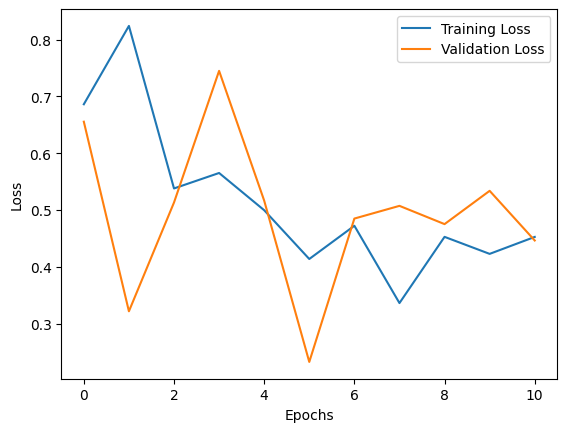

In [9]:
# Plot training & validation accuracy and loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluating The Model

In [10]:
# Predictions on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_val, y_pred_classes)}")
print("Classification Report:")
print(classification_report(y_val, y_pred_classes))

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step
Accuracy: 0.7595870206489675
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       348
           1       0.72      0.82      0.77       330

    accuracy                           0.76       678
   macro avg       0.76      0.76      0.76       678
weighted avg       0.76      0.76      0.76       678



# Confusion Matrix

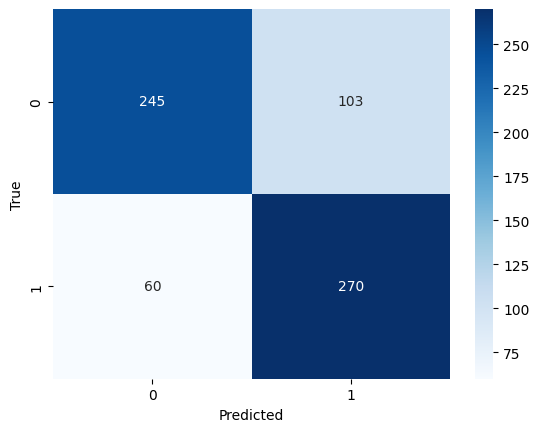

In [11]:
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Fine Tuning

In [12]:
# For example, increasing the depth of the network or using pretrained models like ResNet or EfficientNet
# Fine-tune the optimizer (learning rate, regularization techniques, etc.)
# Fine-tuning the model
from tensorflow.keras.optimizers import Adam

# Lower the learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Optionally unfreeze some layers or keep them all trainable
# For example, unfreeze the last two convolutional blocks:
for layer in model.layers[:-2]:  # Keep the last two layers trainable
    layer.trainable = True

# Train the model again with fine-tuning
fine_tune_history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping])


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.6835 - loss: 0.5597 - val_accuracy: 0.7124 - val_loss: 0.9549
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8705 - loss: 0.2998 - val_accuracy: 0.8569 - val_loss: 0.4115
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9035 - loss: 0.2352 - val_accuracy: 0.8953 - val_loss: 0.3494
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.9270 - loss: 0.1747 - val_accuracy: 0.9056 - val_loss: 0.2111
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9459 - loss: 0.1468 - val_accuracy: 0.9263 - val_loss: 0.2033
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9540 - loss: 0.1309 - val_accuracy: 0.9322 - val_loss: 0.1918
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9473 - loss: 0.1388 - val_accuracy: 0.9351 - val_loss: 0.2058
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9468 - loss: 0.1383 - val_accuracy: 0.9351 -

In [13]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)

# Print the accuracy
print(f'Validation Accuracy: {val_accuracy:.2f}')


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9505 - loss: 0.1861
Validation Accuracy: 0.95
